# Illustrate cancer growth model

In [1]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from exponential_growth_model import ExponentialGrowthModel

The data-generating model is a hierarchical exponential growth model governed
by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (y_0, \lambda, \sigma)$ and
$\theta = (\mu_{y_0}, \mu_{\lambda}, \sigma_{y_0}, \sigma_{\lambda}, \theta_{\sigma})$.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) = \mathcal{N}(y | y_0\mathrm{e}^{\lambda t}, \sigma ^2),
$$

and the inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(y_0 | \mu_{y_0}, \sigma ^2_{y_0})\,
        \mathcal{N}(\lambda | \mu_{\lambda}, \sigma ^2_{\lambda})\,
        \delta (\sigma - \theta_{\sigma}).
$$

## Define model

In [7]:
# Define model
mechanistic_model = ExponentialGrowthModel()
population_model = chi.GaussianModel(
    n_dim=2, dim_names=['Initial count', 'Growth rate'],
    centered=True)

# Define parameters
true_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5]   # Std. exponential growth

Visualise model

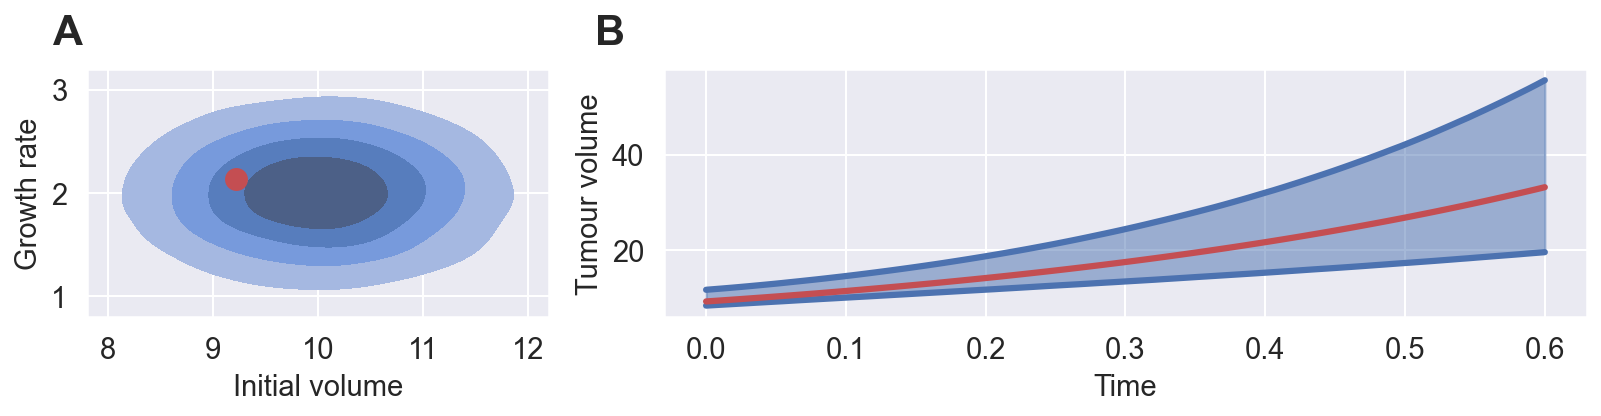

In [32]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    gridspec_kw={'width_ratios': [1, 2]})

# Label subplot groups
axes[0].text(
    -0.075, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[1].text(
    -0.075, 1.1, string.ascii_uppercase[1], transform=axes[1].transAxes,
    size=20, weight='bold')

# Plot data-generating distribution as reference to parameter space
seed = 10
n_samples = 50000
samples = population_model.sample(true_parameters, n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[0])

# Plot data-generating distribution as reference to measurement space
n_steps = 100
times = np.linspace(0, 0.6, num=n_steps)
volumes = np.empty(shape=(n_samples, n_steps))
for ids, s in enumerate(samples):
    volumes[ids] = mechanistic_model.simulate(s, times)
fifth_percentile = np.quantile(volumes, q=0.05, axis=0)
ninetyfifth_percentile = np.quantile(volumes, q=0.95, axis=0)
axes[1].plot(
    times, fifth_percentile, color=sns.color_palette()[0], linewidth=3)
axes[1].plot(
    times, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=3)
axes[1].fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.5)

# Plot individual
_id = 1
axes[0].scatter(
    samples[_id, 0], samples[_id, 1], color=sns.color_palette()[3], s=100)
axes[1].plot(times, volumes[_id], color=sns.color_palette()[3], linewidth=3)

# Legend, ranges axes labels
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel('Tumour volume', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)
axes[0].set_xlim([7.8, 12.2])
axes[0].set_ylim([0.8, 3.2])
axes[0].set_xlabel('Initial volume', fontsize=fontsize)
axes[0].set_ylabel('Growth rate', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)

# Export figure
directory = os.getcwd()
plt.savefig(
    directory + '/0_nlme_model_example.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/0_nlme_model_example.pdf',
    bbox_inches='tight')

plt.tight_layout()